In [1]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import torchvision
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
import os
import numpy as np
import pandas as pd
import random
from PIL import Image
from sklearn.metrics import accuracy_score
import pylab as pl
from IPython import display
from skimage.transform import resize
import datetime

# Defines

In [3]:
class FineGrainedDataset(Dataset):
    
    def __init__(self, csv_path,picture_path, picturesize, transform=True):
        """
        Construct Fine Grained Dataset.
        
        Args
            csv_path: Path to CSV file.
            picturesize: Dimensions of sample images.
            transform: 
        """
        self.transform = transform
        self.picturesize = picturesize
        
        # construct dataframe with onehot notation
        self.df = pd.get_dummies(pd.read_csv(csv_path))
        # create ID column with image file names
        self.df['id'] = self.df['image_id'].apply(lambda x: str(x)) + "_" + self.df['tag_id'].apply(lambda x: str(x)) + ".png"
        # only use class columns and id column
        self.df = self.df.iloc[:, 10:]
        
        #replace -1 with 0
        self.df = self.df.replace(to_replace=-1, value=0)
        
        self.path = picture_path
            
        
    def __getitem__(self, idx):
        """
        Support integer indexing on dataset (range 0 to len(self)).
        """
        sample_id = self.df['id'].iloc[idx]
        
        # get target values for sample
        targets = self.df.loc[idx, self.df.columns != 'id'].values.astype('float32')
        
        # get sample image
        image = np.asarray(Image.open(self.path + sample_id))
        
        # transform sample
        if self.transform:
            img = image
            img_normalized = np.copy(img)
            img_normalized = img_normalized / 255.
            
            img_resized = resize(img_normalized, output_shape=(self.picturesize,self.picturesize), mode='reflect', anti_aliasing=True)[:,:,:3]
            
            sample = {'id': sample_id, 'targets': torch.from_numpy(targets), 'image': torch.from_numpy(img_resized)}
        else:
            sample = {'id': sample_id, 'targets': targets, 'image': image}
        
        return sample
    
    def __len__(self):
        """
        Get length of dataset.
        """
        return len(self.df)
    

In [4]:
def train_valid_split(df, trainsplit_size=0.8):
    """
    Split a dataset in training- and validation split.

    Split is made by splitting the least represented class first
    and the highest represented class last.

    Function is made for multilabel problems where samples that are already 
    drawn from a previous class are not drawn again, and the ratio of the 
    split is calculated at each class from the previous draws to match the 
    split criteria.

    Args
        df: A dataframe which the split should be created from.
            The indexes should be the ID's of the samples.
        trainsplit_size: The size of the training split. 
                         Should be a float in the interval [0, 1]
    """
    # placeholders
    cls = {}
    train_idx = []
    valid_idx = []
    
    df_cls = df.loc[:, df.columns != 'id']

    # get number of occurrences for each class
    for col in df_cls:
        size = len(df_cls.loc[df_cls[col] == 1])
        cls[col] = size

    # sort classes by ascending
    cls_sorted = sorted(cls.items(), key=lambda value: value[1])

    # iterate over classes from least represented class
    # and draw samples for training- and validation split
    for col in cls_sorted:
        # get indexes for samples where class value is 1
        indexes = df_cls.loc[df_cls[col[0]] == 1].index

        # Remove indexes that already are appended to test_idx array
        indexes = [indexes[i] for i in range(len(indexes)) if indexes[i] not in valid_idx and indexes[i] not in train_idx]

        # get size of how many indexes should be drawn for train
        train_size = int(len(indexes) * trainsplit_size)

        # get indexes for train- and validation split
        idx_train = [indexes[i] for i in sorted(random.sample(range(len(indexes)), train_size))]
        idx_valid = [indexes[i] for i in range(len(indexes)) if indexes[i] not in idx_train]

        # save indexes
        train_idx.extend(idx_train)
        valid_idx.extend(idx_valid)
        
    print("Number of samples in provided dataset: {}\n".format(len(df_cls)))
    print("Split criteria\ntrain size: {:.2f} %\nvalid size: {:.2f} %".format(trainsplit_size*100, 
                                                                   (1-trainsplit_size)*100))
    print("\nSplit results")
    print("Train size:\t{}\t({:.2f} %)".format(len(train_idx), \
                                               (len(train_idx) / len(df_cls)) * 100))
    print("Val size:\t{}\t({:.2f} %)".format(len(valid_idx), \
                                     (len(valid_idx) / len(df_cls)) * 100))

    return train_idx, valid_idx


In [14]:
#define the model
model_conv = models.resnet50(pretrained='imagenet')

# disable autograd for resnet
for param in model_conv.parameters():
    param.requires_grad = False
    
# Change fully connected layer to match paper (autograd is default on new layers)
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 1024)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_conv = model_conv.to(device)

In [15]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  
        # input layer
        output_nodes = dataset.df.shape[1]-1
        self.output = nn.Linear(1024,output_nodes)
       

    def forward(self, x):
        x = model_conv(x)
        x = F.relu(x)
        x = self.output(x)
        x = torch.sigmoid(x)
        return x





# Code

In [5]:
dataset = FineGrainedDataset(csv_path='./dataset_v2/train.csv',picture_path='./dataset_v2/root/train/cropped/', picturesize=224, transform=True)
train_indexes, valid_indexes = train_valid_split(dataset.df)

Number of samples in provided dataset: 11617

Split criteria
train size: 80.00 %
valid size: 20.00 %

Split results
Train size:	9281	(79.89 %)
Val size:	2336	(20.11 %)


In [6]:
BATCH_SIZE = 64

trainsampler = SubsetRandomSampler(train_indexes)
validsampler = SubsetRandomSampler(valid_indexes)

samplers = {'train': trainsampler,
            'valid': validsampler}

trainloader = DataLoader(dataset=dataset,
                         batch_size=BATCH_SIZE,
                         sampler=samplers['train'],
                         num_workers=4)
validloader = DataLoader(dataset=dataset,
                         batch_size=BATCH_SIZE,
                         sampler=samplers['valid'],
                         num_workers=4)

dataloaders = {'train': trainloader,
               'valid': validloader}

dataset_sizes = {x: len(samplers[x]) for x in ['train', 'valid']}

In [28]:
#get batch
for batch in dataloaders['train']:
        inputs = batch['image'].permute(0, 3, 1, 2)
        labels = batch['targets']
        inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
        break

In [27]:
pic1 = dataset[0:63]['image'].to(device)
label1 = dataset[0]['targets'].to(device)
pic2 = dataset[1]['image'].to(device)
label2 = dataset[1]['targets'].to(device)
pic3 = dataset[2]['image'].to(device)
label3 = dataset[2]['targets'].to(device)

AttributeError: 'Series' object has no attribute 'read'

# Load models

In [17]:
PATH = "./models/100epochs-customloss-lr0.002-momentum0.9"
net1 = torch.load(PATH+".pt").to(device)

PATH = "./models/100epochs-bceloss-lr0.01-momentum0.9"
net2 = torch.load(PATH+".pt").to(device)

In [29]:
pred1 =net1(inputs)
pred2 =net2(inputs)

#pic2_pred1 =net1(pic2)
#pic2_pred2 =net2(pic2)

#pic3_pred1 =net1(pic3)
#pic3_pred2 =net2(pic3)

In [34]:
inputs[:3]

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
        

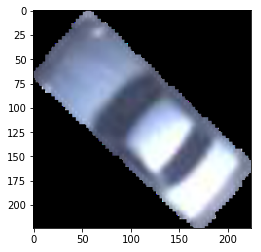

prediction was ['sunroof', 'general_class_large vehicle', 'general_class_small vehicle', 'sub_class_hatchback', 'sub_class_jeep', 'sub_class_minivan', 'sub_class_sedan', 'color_black', 'color_blue', 'color_other', 'color_silver/grey', 'color_white']
label was ['general_class_small vehicle', 'sub_class_sedan', 'color_silver/grey']


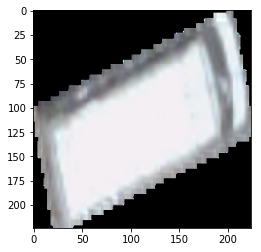

prediction was ['sunroof', 'wrecked', 'general_class_large vehicle', 'general_class_small vehicle', 'sub_class_hatchback', 'sub_class_jeep', 'sub_class_sedan', 'color_black', 'color_other', 'color_silver/grey', 'color_white']
label was ['general_class_small vehicle', 'sub_class_van', 'color_white']


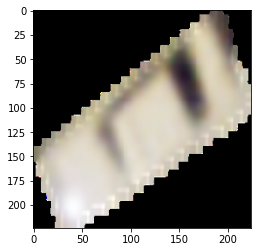

prediction was ['sunroof', 'wrecked', 'general_class_large vehicle', 'general_class_small vehicle', 'sub_class_hatchback', 'sub_class_jeep', 'sub_class_minivan', 'sub_class_sedan', 'color_black', 'color_blue', 'color_silver/grey', 'color_white']
label was ['general_class_small vehicle', 'sub_class_sedan', 'color_silver/grey']


In [35]:
threshold = 0.5
i = 0
for pred,label in zip(pred1[:3],labels[:3]):
    pred = [dataset.df.columns[i] for i,pred in enumerate(pred) if pred > threshold]
    label = [dataset.df.columns[i] for i,pred in enumerate(label) if pred > threshold]
    img = inputs[i].cpu().numpy().transpose((1, -1, 0)) #transpose(1,-1,0)
    pl.imshow(img);
    pl.show()
    print("prediction was {}".format(pred))
    print("label was {}".format(label))
    picUpdate = datetime.datetime.now() + datetime.timedelta(seconds=1)
    i += 1
    #display.clear_output(wait=True)

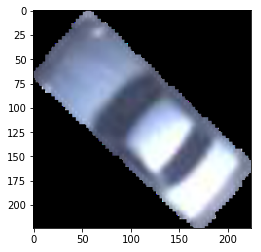

prediction was ['general_class_small vehicle', 'color_white']
label was ['general_class_small vehicle', 'sub_class_sedan', 'color_silver/grey']


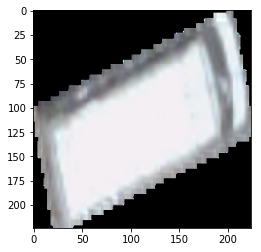

prediction was ['general_class_small vehicle', 'color_white']
label was ['general_class_small vehicle', 'sub_class_van', 'color_white']


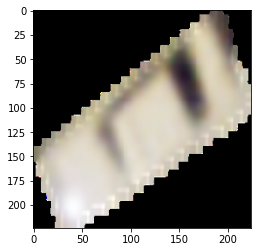

prediction was ['general_class_small vehicle', 'sub_class_sedan', 'color_white']
label was ['general_class_small vehicle', 'sub_class_sedan', 'color_silver/grey']


In [36]:
threshold = 0.5
i = 0
for pred,label in zip(pred2[:3],labels[:3]):
    pred = [dataset.df.columns[i] for i,pred in enumerate(pred) if pred > threshold]
    label = [dataset.df.columns[i] for i,pred in enumerate(label) if pred > threshold]
    img = inputs[i].cpu().numpy().transpose((1, -1, 0)) #transpose(1,-1,0)
    pl.imshow(img);
    pl.show()
    print("prediction was {}".format(pred))
    print("label was {}".format(label))
    picUpdate = datetime.datetime.now() + datetime.timedelta(seconds=1)
    i += 1
    #display.clear_output(wait=True)

In [4]:
PATH = "./models/100epochs-customloss-lr0.002-momentum0.9"
#torch.save(net, PATH+".pt")
losses_train= pd.read_csv(PATH+"Loss_train.csv")
losses_valid = pd.read_csv(PATH+"Loss_valid.csv")
accuracy = pd.read_csv(PATH+"MAP.csv")

In [6]:
#################### plotting ###############################    
#pl.imshow(img);
#pl.show()
#print("prediction was {}".format(pred))
#print("label was {}".format(label))    
# Final plot    
pl.figure(figsize=(15,5))
pl.xlabel('Epochs')
pl.ylabel('Loss')
pl.title('Epoch #{}'.format(epo))
pl.plot(losses_train['Epoch'],losses_train['Loss'], '-b', label='Train')
pl.plot(losses_valid['Epoch'],losses_valid['Loss'], '-r', label='Valid')
pl.legend()
pl.show()
#plot MAP
pl.figure(figsize=(15,5))
pl.xlabel('Epochs')
pl.ylabel('MAP')
pl.title('Epoch #{}'.format(100))
pl.plot(accuracy['Epoch'],accuracy['MAP'], '-b')
pl.legend()
pl.show()
    #

print('Training loss: {:.2f}'.format(losses_train['Loss'].iloc[-1],))
print('Validation loss:{:.2f}\tValidation MAP: {:.2f}'.format(losses_valid['Loss'].iloc[-1],accuracy['MAP'].iloc[-1]))

#end = datetime.datetime.now()


NameError: name 'epoch' is not defined